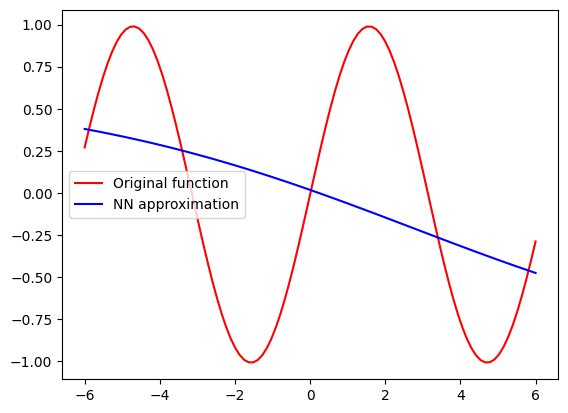

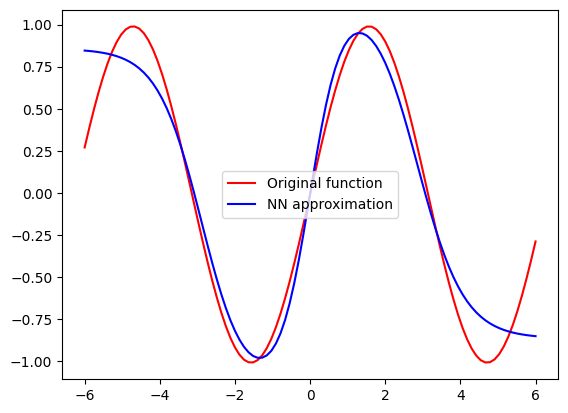

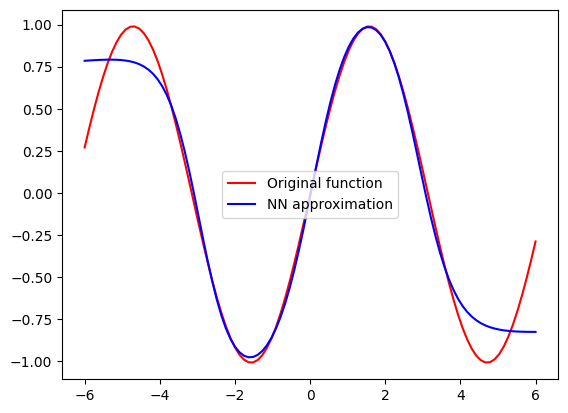

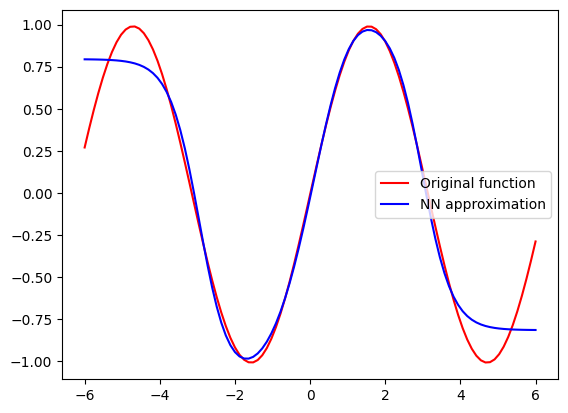

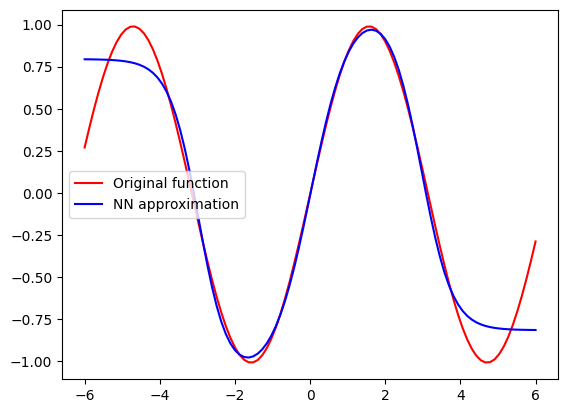

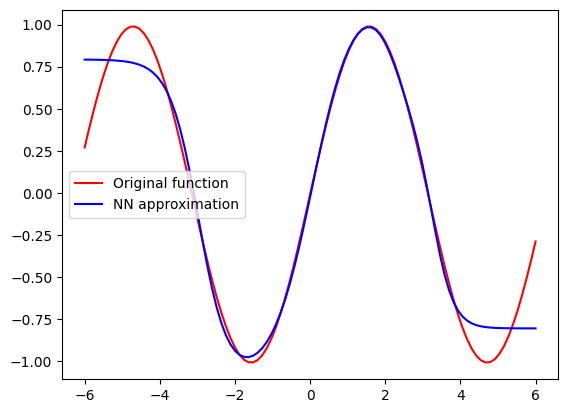

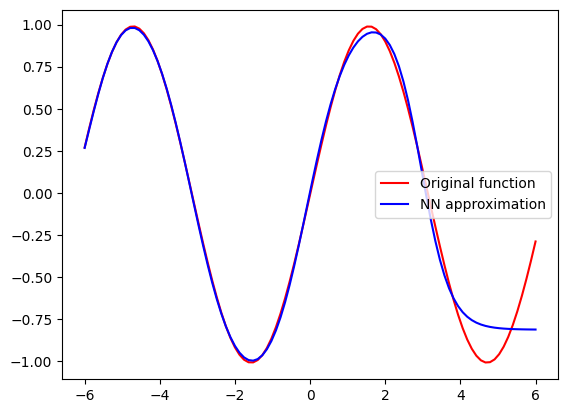

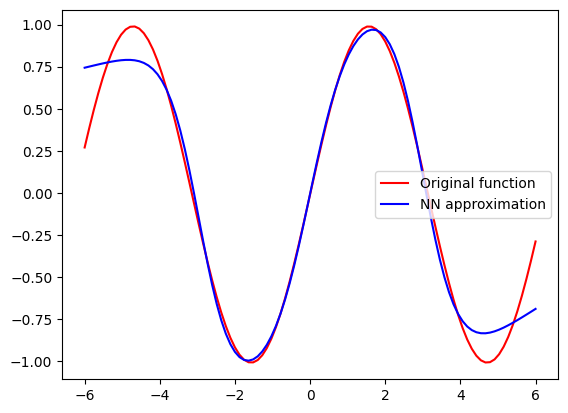

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def myfunc(ranged):
    # Define the function
    def func(x):
        return np.sin(x) - 0.1**2

    # Create the dataset
    x = np.linspace(-6, 6, 100)
    y = func(x)

    # Convert data to tensors
    x_tensor = torch.Tensor(x).unsqueeze(-1)
    y_tensor = torch.Tensor(y).unsqueeze(-1)

    # Define the model
    model = nn.Sequential(
        nn.Linear(1, 4),
        nn.Sigmoid(),
        nn.Linear(4, 1),
    )

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    for epoch in range(ranged):
        # Forward pass
        outputs = model(x_tensor)
        loss = criterion(outputs, y_tensor)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (epoch+1) % 1000 == 0:
        #     print (f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Test the model
    model.eval()
    with torch.no_grad():
        predictions = model(x_tensor)

    # Plotting original function and the approximation
    plt.plot(x_tensor, y_tensor, 'r', label='Original function')
    plt.plot(x_tensor, predictions, 'b', label='NN approximation')
    plt.legend()
    plt.show()

myfunc(100)
myfunc(500)
myfunc(1000)
myfunc(2000)
myfunc(3000)
myfunc(5000)
myfunc(10000)
myfunc(2000)




In [ ]:
import pandas as pd
import numpy as np
import psycopg2

conn  = psycopg2.connect(host="65.109.54.241", user="root", port=5432, database="W9sV6cL2dX", password="E5rG7tY3fH")





# define your query
query = """
    SELECT * FROM item_txt_content Where language = 'english'
        """

# execute the query and load the result into a  DataFrame
df = pd.read_sql_query(query, conn)

# make sure to close the connection
conn.close()

In [ ]:
data = df[['item_key','content']]

#find rows with missing values
data[data.isnull().any(axis=1)]
#drop rows with missing values
data.dropna(inplace=True)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")


def is_english(text, tokenizer, english_vocab):
    tokens = tokenizer.tokenize(text)
    if len(tokens) == 0:
        return False
    english_tokens = [token for token in tokens if token in english_vocab]
    return len(english_tokens)  > 5  # More than half of tokens are English

# English vocab could be a set of common English words or the English vocabulary from the SentencePiece model
english_vocab = set(["the", "is", "are", "..."])

# Apply this function to your text data
data["is_english"] = data["content"].apply(lambda text: is_english(text, tokenizer, english_vocab))

In [ ]:
processed_true = data[data['is_english'] == True]

In [ ]:
processed_false = data[data['is_english'] == False]

In [ ]:
edf = df[df['language'] == 'english']

In [ ]:
cdf= df[['item_key','sentiment']]

In [24]:
#inner join cdf with processed_true on item_key
cdf = pd.merge(cdf, processed_true, on='item_key', how='inner')
cdf

NameError: name 'cdf' is not defined

In [ ]:
!pip install simpletransformers

In [42]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Preparing train data
english_data = cdf.sample(frac=0.4)  

# Map sentiments to numbers
sentiment_mapping = {"sad": 0, "surprising": 1, "funny": 2, "fearful": 3, "inspiring": 4}
english_data["sentiment"] = english_data["sentiment"].map(sentiment_mapping)

train_df = english_data[['content', 'sentiment']]

# Setting up the model arguments
model_args = ClassificationArgs(num_train_epochs=15)  # reduce the number of epochs

# Create a ClassificationModel
model = ClassificationModel(
    "distilbert", "distilbert-base-uncased", num_labels=5, args=model_args, use_cuda=True
)

# Train the model
model.train_model(train_df)

# Predictions and Evaluation
eval_df = english_data[['content', 'sentiment']].sample(100)  # Sample 100 instances for example

# Get the text from the DataFrame
texts = eval_df['content'].tolist()

# Predict
predictions, raw_outputs = model.predict(texts)

# Add predictions to the DataFrame
eval_df['predicted_sentiment'] = predictions

# Map predictions back to sentiment labels
reverse_sentiment_mapping = {value: key for key, value in sentiment_mapping.items()}
eval_df['predicted_sentiment'] = eval_df['predicted_sentiment'].map(reverse_sentiment_mapping)

model.save_model("classification_model")

# model = ClassificationModel("bert", "bert-base-uncased").load_model("classification_model")

english_data = cdf
# Predictions and Evaluation
eval_df1 = english_data[['item_key','content', 'sentiment']]  # Sample 100 instances for example

# Get the text from the DataFrame
texts1 = eval_df1['content'].tolist()

# Predict
predictions, raw_outputs = model.predict(texts1)

# Add predictions to the DataFrame 
eval_df1['predicted_sentiment'] = predictions

# Map predictions back to sentiment labels
reverse_sentiment_mapping = {value: key for key, value in sentiment_mapping.items()}
eval_df1['predicted_sentiment'] = eval_df1['predicted_sentiment'].map(reverse_sentiment_mapping)

eval_df1.to_csv('eval_df5.csv', index=False)

#find rows where sentiment & predicted_sentiment are different




/tmp/ipykernel_87493/1647623431.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/tmp/ipykernel_87493/1647623431.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
/tmp/ipykernel_87493/1647623431.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["is_english"] = data["content"].apply(lambda text: is_english(text, tokenizer, english_voc

KeyboardInterrupt: 

/tmp/ipykernel_87493/3988221021.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [18]:
data

,item_key,content
0,c8293ca4-ecd9-4629-9094-1776e030b019,C'era una volta un uomo di nome Marco che avev...
1,03b743b5-aac0-4e6e-8f09-874710197967,تعتبر السيارة، الدراجة، ومضرب التنس من الأدوات...
2,f0ed10bd-e90c-4ffa-8f49-68e5b4a95028,"C'era una volta una palla da basket, una mela ..."
3,afce50a1-d2e1-42d7-8b2b-43c61e33d59f,"Here's my attempt at a short, humorous comedy:..."
4,35fe0862-7167-4126-90c0-ba26333f3a7b,مرة واحدة كانت هناك كرة سلة تريد أن تلعب مع حص...
...,...,...
103946,26cfa2a8-0cec-4cfe-9dd7-64bc78bc0011,"Once upon a time, there was a soccer ball, an ..."
103947,f2b9574b-bce3-47f4-a969-67231d3223f2,أهلا بك في درس حزين قصير حول الحصان والكرسي. ل...
103948,0fcde70f-0478-4c6d-baf0-8f2e4b5cce29,مرحبًا! شكرًا لثقتك بخدماتي. هذه فرصة رائعة لأ...
103949,f31357cb-d08c-4a44-b9bd-3426e7e9e387,كان هناك صبي صغير يعشق التنس، لكن لم يكن لديه ...


In [6]:
import pandas as pd

#read csv eval_df1.csv
edf1 = pd.read_csv('eval_df1.csv')

edf1

#find all rows where sentiment and predicted_sentiment are not equal


,item_key,content,sentiment,predicted_sentiment
0,afce50a1-d2e1-42d7-8b2b-43c61e33d59f,"Here's my attempt at a short, humorous comedy:...",fearful,fearful
1,557cf019-eed5-4f31-85f7-fe6724535518,"Sure, I can give it a try! \n\nOne time, a tru...",surprising,funny
2,bfc73c7b-8c5f-44da-a618-fc7c44476290,Learning to play the guitar is like riding a h...,inspiring,inspiring
3,7337fabd-f397-495e-bdb9-2c5187b9193b,"Once upon a time, there was a small bird who l...",fearful,fearful
4,e91934e6-54f2-4ce9-aa91-6696e690ec30,Here's a short funny comedy about a rugby ball...,funny,funny
...,...,...,...,...
21566,37718d19-0e80-4e7d-9368-f9e5860a6171,Once there was a young boy who loved playing b...,inspiring,inspiring
21567,e4fab5b9-da27-418c-8f89-16f30d7ba249,"One day, a truck driver was cruising down the ...",funny,surprising
21568,ac0288c0-034f-476a-9828-d7e4c982b78f,Are you ready to learn how to make an airplane...,funny,funny
21569,03583663-0019-4f8e-a32e-776b35b15ace,"Once upon a time, there was a horse named Patt...",funny,funny


In [22]:
import pandas as pd
#read csv eval_df1.csv
edf2 = pd.read_csv('eval_df2.csv')
edf3 = pd.read_csv('eval_df3.csv')
edf4 = pd.read_csv('eval_df4.csv')
edf5 = pd.read_csv('eval_df5.csv')
edf6 = pd.read_csv('eval_df6.csv')
edf2


,item_key,content,sentiment,predicted_sentiment
0,afce50a1-d2e1-42d7-8b2b-43c61e33d59f,"Here's my attempt at a short, humorous comedy:...",fearful,fearful
1,557cf019-eed5-4f31-85f7-fe6724535518,"Sure, I can give it a try! \n\nOne time, a tru...",surprising,inspiring
2,bfc73c7b-8c5f-44da-a618-fc7c44476290,Learning to play the guitar is like riding a h...,inspiring,inspiring
3,7337fabd-f397-495e-bdb9-2c5187b9193b,"Once upon a time, there was a small bird who l...",fearful,fearful
4,e91934e6-54f2-4ce9-aa91-6696e690ec30,Here's a short funny comedy about a rugby ball...,funny,funny
...,...,...,...,...
21566,37718d19-0e80-4e7d-9368-f9e5860a6171,Once there was a young boy who loved playing b...,inspiring,inspiring
21567,e4fab5b9-da27-418c-8f89-16f30d7ba249,"One day, a truck driver was cruising down the ...",funny,surprising
21568,ac0288c0-034f-476a-9828-d7e4c982b78f,Are you ready to learn how to make an airplane...,funny,funny
21569,03583663-0019-4f8e-a32e-776b35b15ace,"Once upon a time, there was a horse named Patt...",funny,funny


In [25]:
print('0.1 Sample 2 epochs. Accuracy:', end=" ")
print(len(edf1[edf1['sentiment'] == edf1['predicted_sentiment']])/len(edf1)) 
print('0.1 Sample 5 epochs. Accuracy:', end=" ")
print(len(edf2[edf2['sentiment'] == edf2['predicted_sentiment']])/len(edf2))
print('0.3 Sample 10 epochs. Accuracy:', end=" ")
print(len(edf3[edf3['sentiment'] == edf3['predicted_sentiment']])/len(edf3))
print('0.3 Sample 15 epochs. Accuracy:', end=" ")
print(len(edf4[edf4['sentiment'] == edf4['predicted_sentiment']])/len(edf4))
print('0.4 Sample 15 epochs. Accuracy:', end=" ")
print(len(edf5[edf5['sentiment'] == edf5['predicted_sentiment']])/len(edf5))
print('0.001 Sample 10 epochs. Accuracy:', end=" ")
print(len(edf6[edf6['sentiment'] == edf6['predicted_sentiment']])/len(edf6))


0.1 Sample 2 epochs. Accuracy: 0.7465578786333503
0.1 Sample 5 epochs. Accuracy: 0.756617681145983
0.3 Sample 10 epochs. Accuracy: 0.8212414816188401
0.3 Sample 15 epochs. Accuracy: 0.8249038060358815
0.4 Sample 15 epochs. Accuracy: 0.853738816002967
0.001 Sample 10 epochs. Accuracy: 0.6338602753697093


,item_key,bucket_key,type,url,content,genre,topics,sentiment,ctype,language
3,afce50a1-d2e1-42d7-8b2b-43c61e33d59f,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,"Here's my attempt at a short, humorous comedy:...",humorous comedy,"[""automobile"", ""bicycle"", ""rugby ball""]",fearful,text/plain,english
6,b8198bc0-b4f5-452a-a7db-319baa1bc42d,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,"I'm sorry, but as an AI language model, I cann...",tutorial,"[""apple"", ""cat"", ""basketball ball""]",sad,text/plain,english
7,557cf019-eed5-4f31-85f7-fe6724535518,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,"Sure, I can give it a try! \n\nOne time, a tru...",humorous comedy,"[""truck"", ""airplane""]",surprising,text/plain,english
8,bfc73c7b-8c5f-44da-a618-fc7c44476290,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,Learning to play the guitar is like riding a h...,tutorial,"[""horse"", ""grapes"", ""guitar""]",inspiring,text/plain,english
12,7337fabd-f397-495e-bdb9-2c5187b9193b,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,"Once upon a time, there was a small bird who l...",story,"[""bird"", ""cat""]",fearful,text/plain,english
...,...,...,...,...,...,...,...,...,...,...
103925,e4fab5b9-da27-418c-8f89-16f30d7ba249,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,"One day, a truck driver was cruising down the ...",humorous comedy,"[""truck"", ""airplane"", ""cat""]",funny,text/plain,english
103928,15d8b204-d6e5-4ff9-b3e7-c847972b5949,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,"I'm sorry, I cannot fulfill this request. As a...",tutorial,"[""banana"", ""horse"", ""brocolli""]",sad,text/plain,english
103933,ac0288c0-034f-476a-9828-d7e4c982b78f,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,Are you ready to learn how to make an airplane...,tutorial,"[""airplane"", ""truck"", ""ship""]",funny,text/plain,english
103942,03583663-0019-4f8e-a32e-776b35b15ace,tiny-texts-jk9apq,txt,https://tiny-texts-jk9apq.s3.us-east-1.amazona...,"Once upon a time, there was a horse named Patt...",story,"[""horse"", ""airplane"", ""cat""]",funny,text/plain,english


In [34]:
cdf

,item_key,sentiment
0,c8293ca4-ecd9-4629-9094-1776e030b019,inspiring
1,03b743b5-aac0-4e6e-8f09-874710197967,inspiring
2,f0ed10bd-e90c-4ffa-8f49-68e5b4a95028,funny
3,afce50a1-d2e1-42d7-8b2b-43c61e33d59f,fearful
4,35fe0862-7167-4126-90c0-ba26333f3a7b,sad
...,...,...
103946,26cfa2a8-0cec-4cfe-9dd7-64bc78bc0011,funny
103947,f2b9574b-bce3-47f4-a969-67231d3223f2,sad
103948,0fcde70f-0478-4c6d-baf0-8f2e4b5cce29,inspiring
103949,f31357cb-d08c-4a44-b9bd-3426e7e9e387,inspiring


,item_key,sentiment,content,is_english
0,afce50a1-d2e1-42d7-8b2b-43c61e33d59f,fearful,"Here's my attempt at a short, humorous comedy:...",True
1,557cf019-eed5-4f31-85f7-fe6724535518,surprising,"Sure, I can give it a try! \n\nOne time, a tru...",True
2,bfc73c7b-8c5f-44da-a618-fc7c44476290,inspiring,Learning to play the guitar is like riding a h...,True
3,7337fabd-f397-495e-bdb9-2c5187b9193b,fearful,"Once upon a time, there was a small bird who l...",True
4,e91934e6-54f2-4ce9-aa91-6696e690ec30,funny,Here's a short funny comedy about a rugby ball...,True
...,...,...,...,...
21466,37718d19-0e80-4e7d-9368-f9e5860a6171,inspiring,Once there was a young boy who loved playing b...,True
21467,e4fab5b9-da27-418c-8f89-16f30d7ba249,funny,"One day, a truck driver was cruising down the ...",True
21468,ac0288c0-034f-476a-9828-d7e4c982b78f,funny,Are you ready to learn how to make an airplane...,True
21469,03583663-0019-4f8e-a32e-776b35b15ace,funny,"Once upon a time, there was a horse named Patt...",True


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 0/215 [03:51<?, ?it/s]


KeyboardInterrupt: 